In [2]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import functional as F


from nbeats_pytorch.model import NBeatsNet
from trainer_pytorch import save

warnings.filterwarnings(action='ignore', message='Setting attributes')


In [3]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,x,y):
        my_loss = torch.mean(torch.abs((x - y)/y))
        return  my_loss


In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# # 读取 CSV 文件
# df = pd.read_csv('data/new test.csv')
#
# # 标准化处理 season 列
# # scaler = StandardScaler()
# scaler = MinMaxScaler()
# season_norm = scaler.fit_transform(df[['avg_load']])
#
# # 将标准化后的 season 数据添加到原始数据框中
# df['season_norm'] = season_norm
#
# # 将处理后的数据存储到新的 CSV 文件中
# df.to_csv('data/STL_N-BEATS/seasonal_normalized.csv', index=False, columns=['date', 'season_norm'])
#
# 因为原来electric曲线太过震荡所以就再进行平滑化
df = pd.read_csv('data/new test.csv',index_col=0, parse_dates=True)
# 计算指数加权移动平均
alpha = 0.7
ema = df['avg_load'].ewm(alpha=alpha, adjust=False).mean()

# 将平滑后的结果保存到新的csv文件
smoothed_df = pd.DataFrame({'avg_load': ema})
smoothed_df.to_csv('data/STL_N-BEATS/smoothed_seasonal.csv')


In [24]:
def main():
    forecast_length = 7
    backcast_length = 47 * forecast_length
    batch_size = 16  # greater than 4 for viz

    # electric = pd.read_csv('data/STL_N-BEATS/smoothed_seasonal.csv', index_col=0, parse_dates=True)
    electric = pd.read_csv('data/STL_N-BEATS/smoothed_seasonal.csv', index_col=0, parse_dates=True)
    true1 = pd.read_csv('data/new test.csv', index_col=0, parse_dates=True)
    # true1 = pd.read_csv('data/output_avg - 3years.csv', index_col=0, parse_dates=True)

    # electricO = pd.read_csv('data/STL_N-BEATS/seasonal_normalized.csv', index_col=0, parse_dates=True)

    # electricO= pd.read_csv('data/STL_N-BEATS/seasonal.csv', index_col=0, parse_dates=True)
    print(electric.head())
    # print(electricO.head())
    electric = electric.values.flatten()  # just keep np array here for simplicity.
    true1 = true1.values.flatten()
    # true1 = true1.values.flatten()
    # electricO = electricO.values.flatten()

    # data backcast/forecast generation.
    x, y = [], []
    for epoch in range(backcast_length, len(electric) - forecast_length):

        x.append(electric[epoch - backcast_length:epoch])
        y.append(electric[epoch:epoch + forecast_length])
    x = np.array(x)
    y = np.array(y)

    # split train/test.
    c = int(len(x) * 0.8)
    print(c)

    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]

    # normalization.  归一化
    norm_constant = np.max(x_train)
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test = x_test / norm_constant, y_test / norm_constant

    # model
    net = NBeatsNet(
        stack_types=( NBeatsNet.TREND_BLOCK,NBeatsNet.SEASONALITY_BLOCK,NBeatsNet.GENERIC_BLOCK),
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        thetas_dim=(2,8,3),
        hidden_layer_units=64,
        share_weights_in_stack=True
    )

    optimiser = optim.Adam(lr=0.002, params=net.parameters())

    grad_step = 0
    for epoch in range(800):
        # train.
        net.train()
        train_loss = []
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
            criterion_neg_train = CustomLoss()
            loss = criterion_neg_train(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            # loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            train_loss.append(loss.item())
            loss.backward()
            optimiser.step()
        train_loss = np.mean(train_loss)

        # test.
        net.eval()
        _, forecast = net(torch.tensor(x_test, dtype=torch.float))
        criterion_neg_test = CustomLoss()
        test_loss = criterion_neg_test(forecast, torch.tensor(y_test, dtype=torch.float)).item()
        # test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
        p = forecast.detach().numpy()
        if epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
            plt.show()

            with torch.no_grad():
                save(net, optimiser, grad_step)
            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
                  f'te_loss (epoch) = {1000 * test_loss:.3f}')

    B = forecast.flatten()
    C= B * norm_constant

    NC = C.detach().numpy()


    NNC = NC.tolist()
    # NNC = NC.reshape(-1, 1)
    # NNC = scaler.inverse_transform(NNC)
    # NNC = NNC.ravel()
    # print('type(NNC)',type(NNC))


    # Text=NNC[len(NNC)-30::]
    # print('Text',Text)




    # electric = electric.tolist()
    # TRU = electric[len(electric)-30::]
    # print('TRU',TRU)
    # print('TRU',len(TRU))
    # print(type(TRU),type(TRU))

    TRU = true1[len(true1)-len(forecast)-forecast_length+1::]
    print('TRU',TRU)
    print('TRU',len(TRU))
    print(type(TRU))


    avg=[]
    # 当len（forecast）< forecast_length
    if  forecast_length>len(forecast):
       for i in range(0,len(forecast)+forecast_length-1):
          if i == 0:
             avg.append(NNC[i])
             pass

          elif 0<i<=len(forecast)-1:
             N = np.mean(NNC[i:forecast_length * i + 1:6])
             avg.append(N)
             pass

          elif forecast_length-1>=i>len(forecast)-1:
             avg.append(np.mean(NNC[i:forecast_length * i + 1:6]))
             pass

          elif len(forecast) + forecast_length - 2 > i > forecast_length-1:
             j = i - forecast_length + 1
             avg.append(np.mean(NNC[i + 6 * j:len(NNC):6]))
             pass

          else:
             c = i - forecast_length+1
             avg.append(NNC[ i + c * 6 ])
             pass
       pass

    # 当len（forecast）= forecast_length
    elif forecast_length == len(forecast):
        for i in range(0,len(forecast)+forecast_length-1):
          if i == 0:
             avg.append(NNC[i])
             pass

          elif 0<i<=len(forecast)-1:
             N = np.mean(NNC[i :4 * i + 1 : 6])
             avg.append(N)
             pass

          elif len(forecast) + forecast_length - 2 > i > forecast_length-1:
             j = i - forecast_length + 1
             avg.append(np.mean(NNC[i + 6 * j:len(NNC):6]))
             pass

          else:
             c = i - forecast_length+1
             avg.append(NNC[ i + c * 6 ])
             pass
        pass

    # 当len（forecast）> forecast_length
    else:
        for i in range(0,len(forecast)+forecast_length-1):
          if i == 0:
             avg.append(NNC[i])
             pass

          elif 0<i<=forecast_length-1:
             N = np.mean(NNC[i:forecast_length * i + 1:6])
             avg.append(N)
             pass

          elif len(forecast)-1>i>forecast_length-1:
             t = i - forecast_length
             avg.append(np.mean(NNC[i + 6 * t : len(NNC) - (len(forecast)-i) * forecast_length - 1 : 6]))
             pass

          # 在这里下端触底了
          elif len(forecast) + forecast_length - 2 > i >= len(forecast)-1:
             j = i - forecast_length + 1
             avg.append(np.mean(NNC[i + 6 * j:len(NNC) - 1 : 6]))
             pass

          else:
             c = i - forecast_length+1
             avg.append(NNC[ i + c * 6 ])
             pass
        pass

    print('avg',avg)
    print(type(avg))





    # MAPE

    APE=[]
    for day in range(len(forecast)+forecast_length-1):
        per_err = (TRU[day] - avg[day]) / TRU[day]
        per_err = abs(per_err)
        APE.append(per_err)
        MAPE = sum(APE)/len(APE)
    print(len(TRU),'天总共预测电量的mape的平均值')
    print('mape :',round(MAPE, 2))
    print('mape % :',round(MAPE*100, 2),'%')
    print('---------------------------------------------')
    EVE=[]
    for day in range(len(TRU)):
        per_err1 = abs((TRU[day] - avg[day]) / TRU[day])
        EVE.append(per_err1*100)
    print(EVE)

    torch.save(net,'STL_N-BEATS(simple1).pth')


if __name__ == '__main__':
    main()


FileNotFoundError: [Errno 2] No such file or directory: 'data/STL_N-BEATS/smoothed_seasonal.csv'

            season_norm
date                   
2007-12-01     0.300047
2007-12-02     0.240306
2007-12-03     0.527040
2007-12-04     0.569585
2007-12-05     0.511278
752
| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=True)
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=124, forecast_length=31, share_thetas=True) at @2363178760264
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=124, forecast_length=31, share_thetas=True) at @2363178760264
     | -- TrendBlock(units=128, thetas_dim=4, backcast_length=124, forecast_length=31, share_thetas=True) at @2363178760264
| --  Stack Seasonality (#1) (share_weights_in_stack=True)
     | -- SeasonalityBlock(units=128, thetas_dim=31, backcast_length=124, forecast_length=31, share_thetas=True) at @2363170613832
     | -- SeasonalityBlock(units=128, thetas_dim=31, backcast_length=124, forecast_length=31, share_thetas=True) at @2363170613832
     | -- SeasonalityBlock(units=128, thetas_dim=31, backcast_length=124

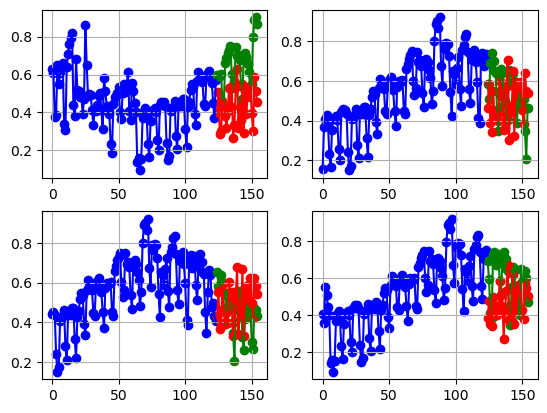

epoch = 0000, grad_step = 000038, tr_loss (epoch) = 134.336, te_loss (epoch) = 47.981


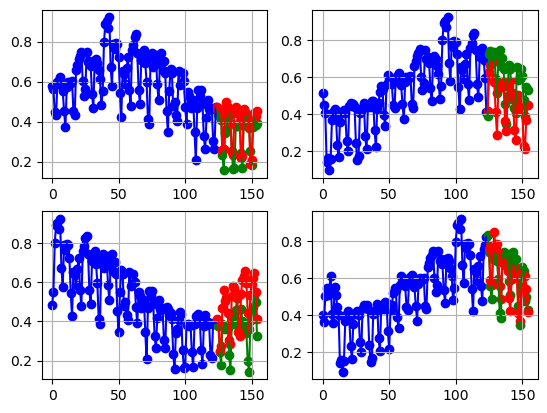

epoch = 0100, grad_step = 003838, tr_loss (epoch) = 7.717, te_loss (epoch) = 9.779


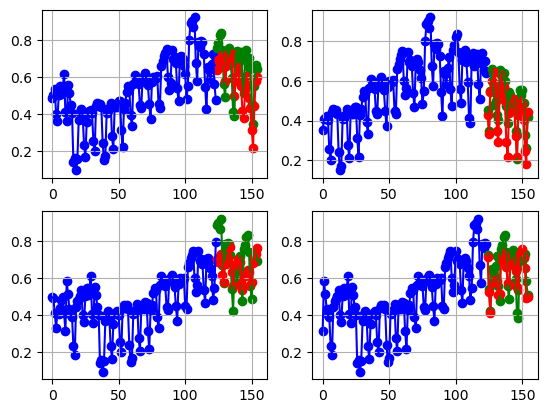

epoch = 0200, grad_step = 007638, tr_loss (epoch) = 4.395, te_loss (epoch) = 12.510


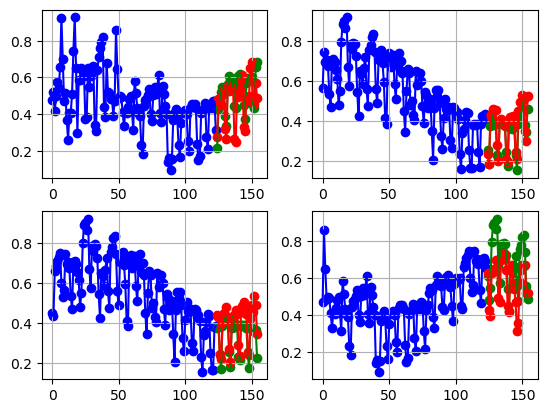

epoch = 0300, grad_step = 011438, tr_loss (epoch) = 2.990, te_loss (epoch) = 11.460


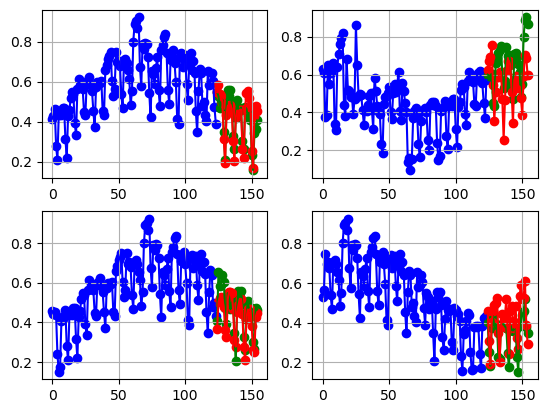

epoch = 0400, grad_step = 015238, tr_loss (epoch) = 2.706, te_loss (epoch) = 12.894


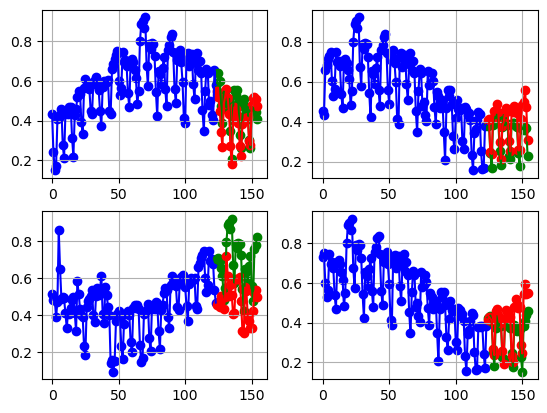

epoch = 0500, grad_step = 019038, tr_loss (epoch) = 2.056, te_loss (epoch) = 11.586


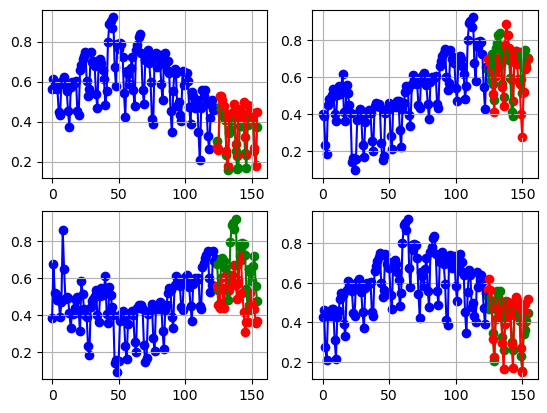

epoch = 0600, grad_step = 022838, tr_loss (epoch) = 1.534, te_loss (epoch) = 12.864


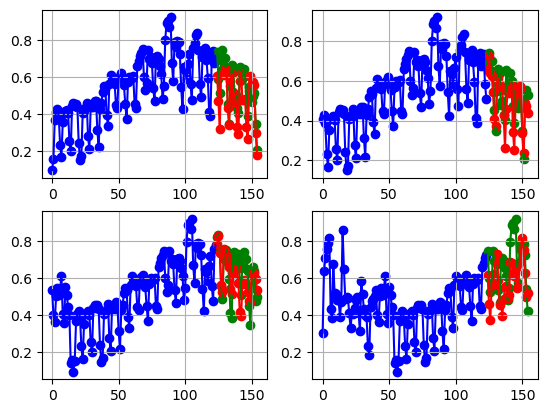

epoch = 0700, grad_step = 026638, tr_loss (epoch) = 1.948, te_loss (epoch) = 12.039


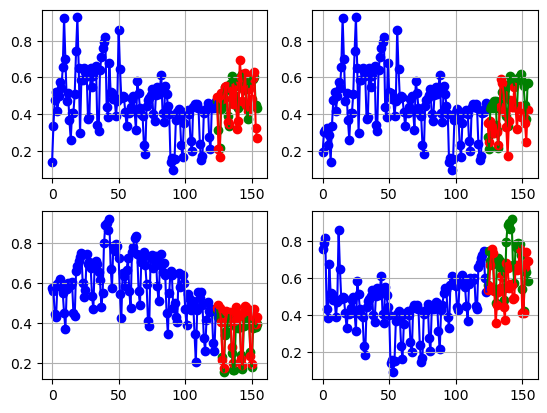

epoch = 0800, grad_step = 030438, tr_loss (epoch) = 1.269, te_loss (epoch) = 12.937


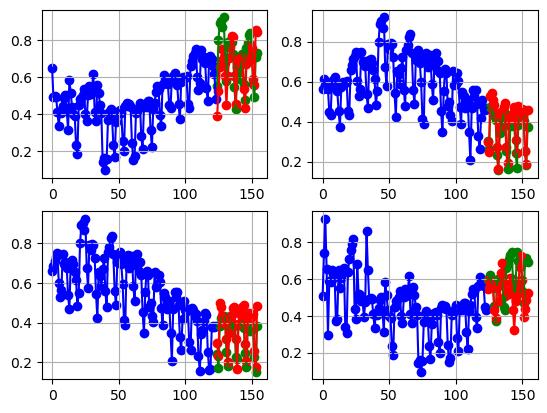

epoch = 0900, grad_step = 034238, tr_loss (epoch) = 1.053, te_loss (epoch) = 13.588


NameError: name 'scaler' is not defined

In [10]:
def main():
    forecast_length = 31
    backcast_length =4 * forecast_length
    batch_size = 20  # greater than 4 for viz

    electric = pd.read_csv('data/STL_N-BEATS/seasonal_normalized.csv', index_col=0, parse_dates=True)
    electricO= pd.read_csv('data/output_avg - 3years.csv', index_col=0, parse_dates=True)
    print(electric.head())
    electric = electric.values.flatten()  # just keep np array here for simplicity.
    electricO = electricO.values.flatten()

    # data backcast/forecast generation.
    x, y = [], []
    for epoch in range(backcast_length, len(electric) - forecast_length):

        x.append(electric[epoch - backcast_length:epoch])
        y.append(electric[epoch:epoch + forecast_length])
    x = np.array(x)
    y = np.array(y)

    # split train/test.
    c = int(len(x) * 0.8)
    print(c)

    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]

    # normalization.  归一化
    norm_constant = np.max(x_train)
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test = x_test / norm_constant, y_test / norm_constant

    # model
    net = NBeatsNet(
        stack_types=( NBeatsNet.TREND_BLOCK,NBeatsNet.SEASONALITY_BLOCK),
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        hidden_layer_units=128,
        share_weights_in_stack=True
    )
    # net = torch.load("model(wu).pth")
    optimiser = optim.Adam(lr=1e-4, params=net.parameters())

    grad_step = 0
    for epoch in range(1000):
        # train.
        net.train()
        train_loss = []
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
            loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            train_loss.append(loss.item())
            loss.backward()
            optimiser.step()
        train_loss = np.mean(train_loss)

        # test.
        net.eval()
        _, forecast = net(torch.tensor(x_test, dtype=torch.float))
        test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
        p = forecast.detach().numpy()
        if epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
            plt.show()

            with torch.no_grad():
                save(net, optimiser, grad_step)
            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
                  f'te_loss (epoch) = {1000 * test_loss:.3f}')

    B = forecast.flatten()
    C= B * norm_constant

    NC = C.detach().numpy()
    # NC = NC.reshape(-1, 1)
    # NC = scaler.inverse_transform(NC)
    # NC = NC.reshape(-1)


    NNC = NC.tolist()
    NNC = NC.reshape(-1, 1)
    NNC = scaler.inverse_transform(NNC)
    NNC = NNC.ravel()
    print('type(NNC)',type(NNC))






    Text=NNC[len(NNC)-31::]
    print('Text',Text)


    TRU = electricO[len(electricO)-31::]
    print('TRU',TRU)
    print('TRU',len(TRU))
    print(type(TRU),type(TRU))






    # MAPE

    APE=[]
    for day in range(len(TRU)):
        per_err = (TRU[day] - Text[day]) / TRU[day]
        per_err = abs(per_err)
        APE.append(per_err)
        MAPE = sum(APE)/len(APE)
    print(len(TRU),'天总共预测电量的mape的平均值')
    print('mape :',round(MAPE, 2))
    print('mape % :',round(MAPE*100, 2),'%')
    print('---------------------------------------------')
    EVE=[]
    for day in range(len(TRU)):
        per_err1 = abs((TRU[day] - Text[day]) / TRU[day])
        EVE.append(per_err1*100)
    print(EVE)

    torch.save(net,'STL_N-BEATS(simple).pth')


if __name__ == '__main__':
    main()